In [1]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext cython

In [2]:
%%cython
#cython: boundscheck=False
def LSE(double[:] x, double[:] y, int n, float bad):

    """
    This is a Least Square Estimate subroutine to fit a linear
    equation for (xi, yi) (i = 1, ..., n), so that yi = a * xi + b
    INPUTs: x(i), y(i), n, (i = 1, ..., n ).
    OUTPUTs: a (slope), b (intercept).
    Li Liu - Sep. 23, 92
    Timothy Lang - Updated for Cython, 05/03/2016
        - Confirmed ~50 times faster than 1-deg np.polyfit()
    """

    cdef:
        float a
        float b
        float xsum = 0.0
        float ysum = 0.0
        float xxsum = 0.0
        float xysum = 0.0
        float det
        float total
        Py_ssize_t i

    total = float(n)
    for i in range(n):
        if x[i] == bad or y[i] == bad:
            total -= 1.0
        else:
            xsum += x[i]
            ysum += y[i]
            xxsum += x[i] * x[i]
            xysum += x[i] * y[i]

    det = total * xxsum - xsum**2
    a = (total * xysum - xsum * ysum) / det
    b = (ysum * xxsum - xsum * xysum) / det
    return a, b

In [3]:
n = 30
x = 1.0 * np.arange(n, dtype='float')
y = 3.0 + 6.0 * np.arange(n, dtype='float')

In [4]:
x.dtype

dtype('float64')

In [5]:
np.polyfit(x, y, 1)

array([ 6.,  3.])

In [6]:
%timeit np.polyfit(x, y, 1)

10000 loops, best of 3: 113 µs per loop


In [7]:
LSE(x, y, 30, -32768)

(6.0, 3.0000147819519043)

In [8]:
%timeit LSE(x, y, n, -32768)

The slowest run took 8.40 times longer than the fastest. This could mean that an intermediate result is being cached 
100000 loops, best of 3: 2.27 µs per loop


In [9]:
for i in range(100, 200, 1):
    print(i, end=' ')

100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 

In [11]:
%%cython
#cython: boundscheck=False

from libc.math cimport sqrt
cimport numpy as np
import numpy as np


def LSE(double[:] x, double[:] y, int n, float bad):
    """
    This is a Least Square Estimate subroutine to fit a linear
    equation for (xi, yi) (i = 1, ..., n), so that yi = a * xi + b
    INPUTs: x(i), y(i), n, (i = 1, ..., n ).
    OUTPUTs: a (slope), b (intercept).
    Li Liu - Sep. 23, 92
    Timothy Lang - Updated for Cython, 05/03/2016
        - Confirmed ~50 times faster than 1-deg np.polyfit()
    """
    cdef:
        float a
        float b
        float xsum = 0.0
        float ysum = 0.0
        float xxsum = 0.0
        float xysum = 0.0
        float det
        float total
        Py_ssize_t i

    total = float(n)
    for i in range(n):
        if x[i] == bad or y[i] == bad:
            total -= 1.0
        else:
            xsum += x[i]
            ysum += y[i]
            xxsum += x[i] * x[i]
            xysum += x[i] * y[i]

    det = total * xxsum - xsum**2
    a = (total * xysum - xsum * ysum) / det
    b = (ysum * xxsum - xsum * xysum) / det
    return a, b


def calc_kdp_ray_fir(
    int ngates, float[:] dp, float[:] dz, float[:] rng,
    float[:] thsd, int nf, float bad, int fir_order, float fir_gain,
    double[:] fir_coeff, int std_gate):
    """
    Arguments
    ---------
    dp = 1D ray of differential phase
    dz = 1D ray of reflectivity
    rng = 1D ray of range
    thsd = Scalar or 1D ray of diff phase stddev thresholds
    nf = Number of times to filter the data
    bad = Bad/missing data value
    fir_order = FIR filter order
    fir_gain = FIR filter gain
    fir_coeff = FIR filter coefficients
    std_gate = Number of gates to use for diff phase stddev calc

    Returns
    -------
    kd_lin = Specific differential phase (deg/km, 1D array)
    dp_lin = Filtered differential phase (deg, 1D array)
    sd_lin = Standard deviation of diff. phase (deg, 1D array)
    """
    # Define needed variables
    cdef:
        np.ndarray[np.float64_t, ndim=1] xx = bad + np.zeros(500, dtype=np.float64)
        np.ndarray[np.float64_t, ndim=1] yy = bad + np.zeros(500, dtype=np.float64)
        np.ndarray[np.float32_t, ndim=1] y = np.zeros(ngates, dtype=np.float32)
        np.ndarray[np.float32_t, ndim=1] z = np.zeros(ngates, dtype=np.float32)
        np.ndarray[np.float32_t, ndim=1] kd_lin = np.zeros(ngates, dtype=np.float32)
        np.ndarray[np.float32_t, ndim=1] dp_lin = np.zeros(ngates, dtype=np.float32)
        np.ndarray[np.float32_t, ndim=1] sd_lin = np.zeros(ngates, dtype=np.float32)
        int half_std_win, nadp, half_fir_win
        int index1, index2, N, half_nadp
        double X, A, V, W, aa, bb
        Py_ssize_t i, j, mloop

    # Half window size for calculating stdev phase
    half_std_win = (std_gate - 1) / 2
    # Half window size for FIR filtering
    half_fir_win = fir_order / 2

    #####################################################################
    # Calculate standard deviation of phidp
    for i in range(ngates):
        kd_lin[i] = bad
        sd_lin[i] = 100.0
        y[i] = bad
        z[i] = dp[i]
        index1 = i - half_std_win
        index2 = i + half_std_win
        if index1 >= 0 and index2 <= ngates - 1:
            N = 0
            A = 0.0
            V = 0.0
            for j in range(index1, index2 + 1, 1):
                if dp[j] != bad:
                    # Standard deviation algorithm
                    X = dp[j]
                    if N <= 0:
                        W = X
                    N += 1
                    D = X - W
                    V = (N - 1) * (D - A)**2 / N + V
                    A = (D - A) / N + A
            if N > half_std_win:
                sd_lin[i] = sqrt(V / N)

    # ------------- MAIN LOOP of Phidp Adaptive Filtering ------------------
    # FIR FILTER SECTION
    for mloop in range(nf):
        for i in range(half_fir_win, ngates - half_fir_win, 1):
            if sd_lin[i] <= thsd[i] and z[i] != bad:
                index1 = i - half_fir_win
                index2 = i + half_fir_win
                N = 0
                for j in range(index1, index2 + 1, 1):
                    if sd_lin[j] <= thsd[j] and z[j] != bad:
                        yy[N] = z[j]
                        xx[N] = rng[j]
                        N += 1

                # Now fill in gaps if they aren't too big
                if float(N) > (0.8 * float(fir_order)):
                    if N < fir_order + 1:
                        aa, bb = LSE(xx, yy, N, bad)
                        for j in range(index1, index2 + 1, 1):
                            if z[j] == bad:
                                z[j] = aa * rng[j] + bb

                    # Now do the FIR filtering
                    A = 0.0
                    for j in range(index1, index2 + 1, 1):
                        A += fir_coeff[j - index1 + 1] * z[j]
                    y[i] = A * fir_gain
        for i in range(ngates):
            z[i] = y[i]  # Enables re-filtering of processed phase
    for i in range(ngates):
        dp_lin[i] = z[i]

    # *****************END LOOP for Phidp Adaptive Filtering******************

    # CALCULATE KDP
    # Default value for nadp is half_fir_win, but varies based on Zh
    for i in range(ngates):
        if dz[i] != bad:
            if dz[i] >= 45.0:
                nadp = half_fir_win
            if dz[i] >= 35.0 and dz[i] < 45.0:
                nadp = 2 * half_fir_win
            if dz[i] < 35.0:
                nadp = 3 * half_fir_win
            half_nadp = nadp / 2
            index1 = i - half_nadp
            index2 = i + half_nadp
            N = 0
            for j in range(index1, index2, 1):
                if index1 >= 0 and index2 <= ngates - 1:
                    if dp_lin[j] != bad:
                        yy[N] = dp_lin[j]
                        xx[N] = rng[j]
                        N += 1
            if float(N) > (0.8 * float(nadp)):
                aa, bb = LSE(xx, yy, N, bad)
                kd_lin[i] = 0.5 * aa

    # *******************END KDP CALCULATION****************************
    return kd_lin, dp_lin, sd_lin

### Testing on file

In [12]:
import os, glob
fdir = '/Users/tjlang/Documents/OVWST/NAME/output/20040805/'
files = sorted(glob.glob(fdir+'*nc'))
for file in files:
    print(os.path.basename(file))

cfrad.20040805_213003.000_to_20040805_214323.000_SPOL_v1_SUR.nc


In [13]:
import pyart
radar = pyart.io.read(files[0])
print(radar.fields.keys())
print(radar.latitude['data'], radar.longitude['data'])
print(radar.fixed_angle['data'])

[u'LD', u'KD', u'ZD', u'DR', u'DB', u'VR', u'HI', u'FD', u'DZ', u'PH', u'RH', u'SD']
[ 23.92897135] [-106.95211372]
[  0.796875   1.296875   1.796875   3.203125   5.796875   8.5       11.109375
  13.796875  16.40625   18.90625   21.5       23.90625   26.40625 ]


In [14]:
def get_ray(radar, field, index):
    return radar.fields[field]['data'][index][:]

In [15]:
dp = get_ray(radar, 'PH', 60)
dz = get_ray(radar, 'DZ', 60)
kdo = get_ray(radar, 'KD', 60)
fdo = get_ray(radar, 'FD', 60)
dz = dz.filled(fill_value=-32768)
sdo = get_ray(radar, 'SD', 60)
rng = radar.range['data'] / 1000.0
print(np.size(dp))

1368


In [16]:
from csu_radartools import csu_kdp
kd1, dp1, sd1 = csu_kdp.calc_kdp_bringi(
    rng=rng, dp=dp, dz=dz, nfilter=1, gs=150, window=3, thsd=12.0)

In [17]:
fir = csu_kdp.get_fir(gs=150, window=3)
thsd = 12.0 + 0.0 * dp
kd2, dp2, sd2 = calc_kdp_ray_fir(len(dp), dp, dz, rng, thsd,
                                 1, -32768, fir['order'], fir['gain'],
                                 fir['coef'], 11)
# print('debug', i, N, z[i], sd_lin[i], thsd[i], index1, index2, half_fir_win, fir_order)

In [18]:
kd3, dp3, sd3 = csu_kdp._calc_kdp_ray(dp, dz, rng, thsd=12, nfilter=1, bad=-32768, fir=fir)

10 loops, best of 3: 165 ms per loop


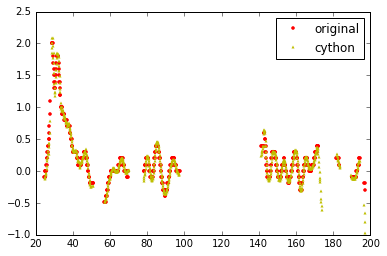

In [27]:
mask1 = dz > -100
mask = np.logical_and(dp1 >= -180, dz > -100)
mask2 = np.logical_and(kd1 > -100, mask)
mask3 = kdo > -100
# plt.plot(rng[mask2], kd1[mask2], 'b*', label='csu_radartools')
plt.plot(rng[mask3], kdo[mask3], 'r.', label='original')
mask = np.logical_and(dp2 >= -180, dz > -100)
mask2 = np.logical_and(kd2 > -100, mask)
plt.plot(rng[mask2], kd2[mask2], 'y^', label='cython', mec='none', ms=3)
mask = np.logical_and(dp3 >= -180, dz > -100)
mask2 = np.logical_and(kd3 > -100, mask)
# plt.plot(rng[mask2], kd3[mask2], 'mD', label='cython', mec='none', ms=2)
plt.ylim([-1, 2.5])
plt.legend(numpoints=1)

In [21]:
%timeit calc_kdp_ray_fir(len(dp), dp, dz, rng, thsd, 1, -32768, fir['order'], \
                         fir['gain'], fir['coef'], 11)

1000 loops, best of 3: 1.81 ms per loop


In [22]:
%timeit csu_kdp.calc_kdp_bringi(rng=rng, dp=dp, dz=dz, nfilter=1, gs=150, window=3)

1000 loops, best of 3: 387 µs per loop


In [23]:
%timeit csu_kdp._calc_kdp_ray(dp, dz, rng, thsd=12, nfilter=1, bad=-32768, fir=fir)

10 loops, best of 3: 160 ms per loop


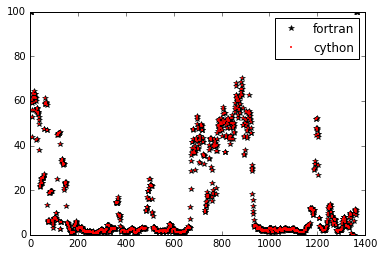

In [24]:
plt.plot(sd1, 'k*', label='fortran')
plt.plot(sd2, 'r.', label='cython', ms=3)
plt.legend(numpoints=1)

(-10, 60)

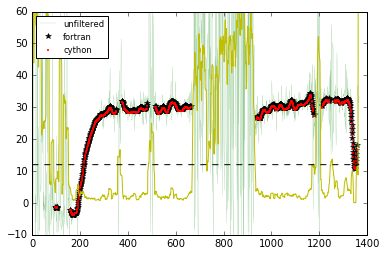

In [26]:
plt.plot(dp, 'g-', label='unfiltered', lw=0.1)
plt.plot(dp1, 'k*', label='fortran')
plt.plot(dp2, 'r.', label='cython', ms=3)
plt.plot(sd2, 'y-')
plt.plot(12.0 + 0.0 * np.arange(len(dp)), 'k--')
plt.legend(numpoints=1, loc='upper left', fontsize='small')
plt.ylim(-10, 60)
# plt.xlim(600, 800)

### Checking loop logic

In [207]:
i = 100
half_fir_win = 10
index1 = i - half_fir_win
index2 = i + half_fir_win

for j in range(index1, index2 + 1, 1):
    print(j, end=' ')

90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 

### Beta function Cython

In [28]:
%%cython
#cython: boundscheck=False

cimport numpy as np
import numpy as np


def hid_beta_f(int ngates, float[:] x_arr, float a, float b, float m):
    """
    Beta function calculator
    ngates = Number of gates
    x_arr = Array to process
    a, b , m = Beta function parameters
    """

    cdef:
        np.ndarray[np.float32_t, ndim=1] beta = np.zeros(ngates, dtype=np.float32)
        Py_ssize_t i

    for i in range(ngates):
        beta[i] = 1.0 / (1.0 + (((x_arr[i] - m) / a)**2.0)**b)

    return beta

(0, 1000)

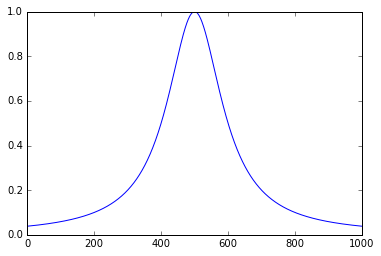

In [48]:
N = 1000
test = hid_beta_f(N, 1.0 * np.arange(N, dtype='float32'), 100.0, 1.0, 500.0)
plt.plot(test)
plt.xlim(0, 1000)